In [1]:
!pip install langchain langchain-community langchain-groq langchain-huggingface \
    sentence-transformers faiss-cpu pypdf bert-score scikit-learn python-dotenv plotly

!pip install deepeval trulens giskard ragas datasets


In [2]:
import os, re
import pandas as pd
from bert_score import score as bert_score
from sklearn.metrics.pairwise import cosine_similarity
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import TokenTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_groq import ChatGroq
from openai import OpenAI

In [3]:
from dotenv import load_dotenv
load_dotenv()
os.environ["GROQ_KEY"] = ""

In [4]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from ragas.evaluation import evaluate
from ragas.metrics import ContextPrecision, ContextRecall, Faithfulness
from datasets import Dataset

In [5]:
DEEPEVAL = TRULENS = GISKARD = RAGAS = False

try:
    import deepeval
    from deepeval.metrics import AnswerRelevancyMetric, FaithfulnessMetric, ContextualRelevancyMetric, ContextualPrecisionMetric, ContextualRecallMetric
    from deepeval.test_case import LLMTestCase
    DEEPEVAL = True
except: pass

try:
    import trulens
    from trulens.feedback import GroundTruthAgreement
    TRULENS = True
except: pass

try:
    import giskard
    GISKARD = True
except: pass

try:
    from ragas.llms import LangchainLLMWrapper
    from ragas.embeddings import LangchainEmbeddingsWrapper
    from ragas.evaluation import evaluate
    from ragas.metrics import ContextPrecision, ContextRecall, Faithfulness
    from datasets import Dataset
    RAGAS = True
except: pass

In [6]:
pdf_filename = 'sample.pdf'
csv_filename = 'qa.csv'


In [7]:
pages = PyPDFLoader(pdf_filename).load()
splitter = TokenTextSplitter(chunk_size=800, chunk_overlap=150)
chunks = splitter.split_documents(pages)
hf_embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
vectorstore = FAISS.from_documents(chunks, hf_embeddings)
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})  #####

qa_df = pd.read_csv(csv_filename).fillna("")
assert all(c in qa_df for c in ["Relevant Chunk IDs", "Reference Answer"])


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
import os
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import Dataset
from ragas import evaluate
from ragas.metrics import (
    context_precision,
    context_recall,
    faithfulness,
    answer_relevancy,
    answer_correctness
)

from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import TokenTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings  # updated import
from langchain.vectorstores import FAISS
from groq import Groq

PDF_PATH      = "sample.pdf"
CSV_PATH      = "qa.csv"
GROQ_API_KEY  = os.getenv("GROQ_KEY")
MODEL_NAME    = "llama3-8b-8192"
TOP_K         = 3

client = Groq(api_key=GROQ_API_KEY)

loader   = PyPDFLoader(PDF_PATH)
pages    = loader.load()
splitter = TokenTextSplitter(chunk_size=800, chunk_overlap=150)
chunks   = splitter.split_documents(pages)

hf_embeddings  = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
vectorstore    = FAISS.from_documents(chunks, hf_embeddings)
retriever      = vectorstore.as_retriever(search_kwargs={"k": TOP_K})

qa_df = pd.read_csv(CSV_PATH).fillna("")
assert all(col in qa_df for col in ["Question", "Reference Answer"])

def retrieve_contexts(question: str) -> list[str]:
    docs = retriever.invoke(question)  # updated method
    return [doc.page_content for doc in docs]

qa_df["contexts"] = qa_df["Question"].apply(retrieve_contexts)

def generate_answer(question, contexts):
    context_block = "\n\n".join(f"[{i+1}] {txt}" for i, txt in enumerate(contexts))
    prompt = (
        "You are an expert factual assistant. Answer using ONLY the provided context; "
        "if insufficient, reply 'Insufficient information.'\n\n"
        f"{context_block}\n\nQuestion: {question}\nAnswer:"
    )
    resp = client.chat.completions.create(
        model=MODEL_NAME,
        messages=[{"role": "user", "content": prompt}],
        temperature=0.0
    )
    return resp.choices[0].message.content.strip()

qa_df["answer"] = qa_df.apply(lambda row: generate_answer(row["Question"], row["contexts"]), axis=1)

In [8]:
def recall_at_k(retrieved, relevant, k):
    return len(set(retrieved[:k]) & set(relevant)) / max(len(set(relevant)), 1)
def precision_at_k(retrieved, relevant, k):
    return len(set(retrieved[:k]) & set(relevant)) / max(k, 1)
def mrr(retrieved, relevant):
    for i, r in enumerate(retrieved, 1):
        if r in relevant: return 1/i
    return 0.0
def answer_relevance(q, a):
    qv, av = hf_embeddings.embed_query(q), hf_embeddings.embed_query(a)
    return float(cosine_similarity([qv],[av])[0][0])
def bertscore(a, ref):
    P, R, F1 = bert_score([a], [ref], lang="en", model_type="bert-base-uncased")
    return float(P[0]), float(R[0]), float(F1[0])


In [26]:
from deepeval.metrics import (
    AnswerRelevancyMetric, FaithfulnessMetric, ContextualRelevancyMetric,
    ContextualPrecisionMetric, ContextualRecallMetric, ToxicityMetric,
    HallucinationMetric
)
from deepeval.test_case import LLMTestCase

def evaluate_with_deepeval(q, a, ctx_list, ref):
    case = LLMTestCase(
        input=q,
        actual_output=a,
        expected_output=ref,
        retrieval_context=ctx_list,
        context=ctx_list  # must be list of strings
    )
    metrics = [
        AnswerRelevancyMetric(),
        FaithfulnessMetric(),
        ContextualRelevancyMetric(),
        ContextualPrecisionMetric(),
        ContextualRecallMetric(),
        ToxicityMetric(),
        HallucinationMetric()
    ]
    results = {}
    for m in metrics:
        m.measure(case)
        results[m.__class__.__name__] = getattr(m, "score", None)
    return results



In [9]:
from google.colab import userdata
os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

,AnswerRelevancyMetric,FaithfulnessMetric,ContextualRelevancyMetric,ContextualPrecisionMetric,ContextualRecallMetric,ToxicityMetric,HallucinationMetric
Q#,,,,,,,
1,1.000,1.000,0.650,1.000,1.000,0.000,0.000
2,1.000,1.000,0.143,0.333,1.000,0.000,0.667
3,0.636,1.000,0.625,0.500,0.000,0.000,0.000
4,1.000,1.000,0.286,0.333,1.000,0.000,0.000
5,1.000,1.000,0.200,1.000,1.000,0.000,0.000
6,0.875,0.800,0.852,1.000,0.500,0.000,0.000
7,1.000,1.000,0.500,0.333,0.500,0.000,0.667
8,1.000,0.000,0.143,1.000,0.000,0.000,0.333
9,0.667,1.000,0.519,0.500,1.000,0.000,0.000


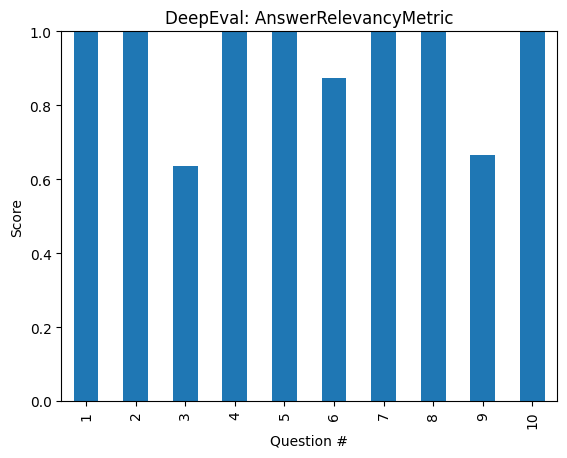

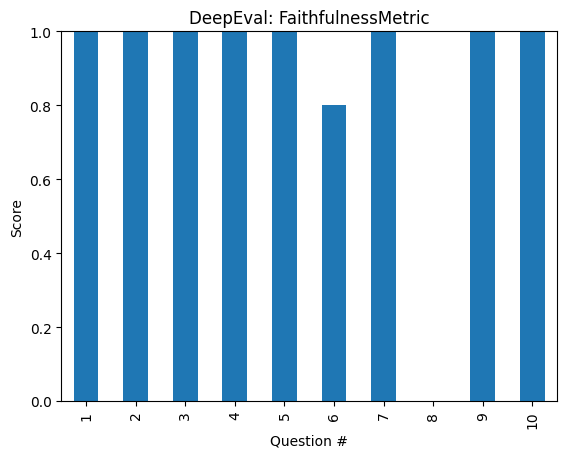

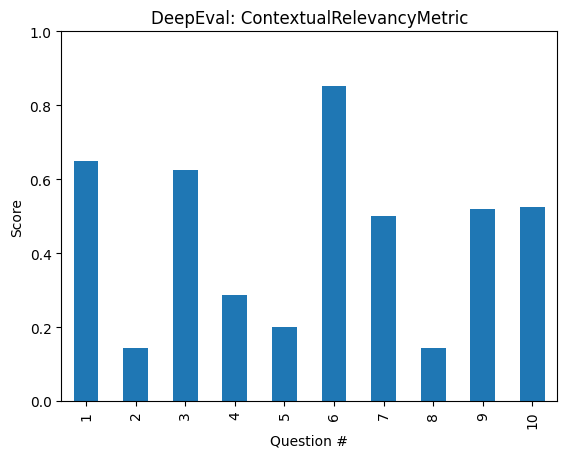

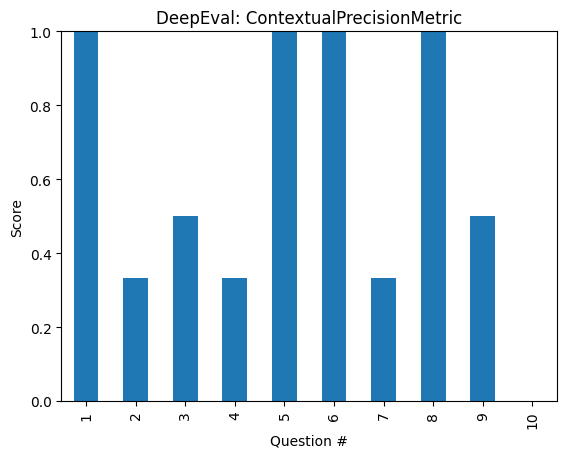

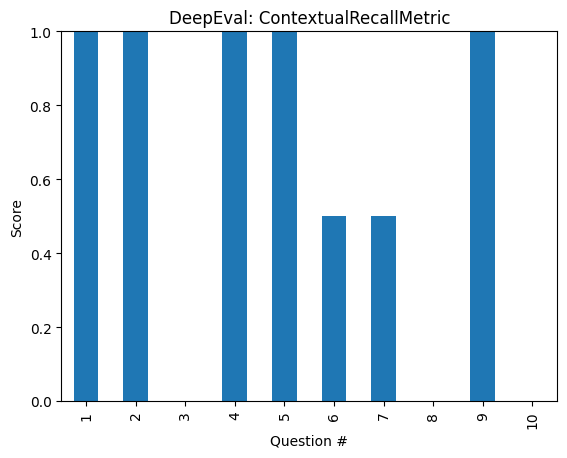

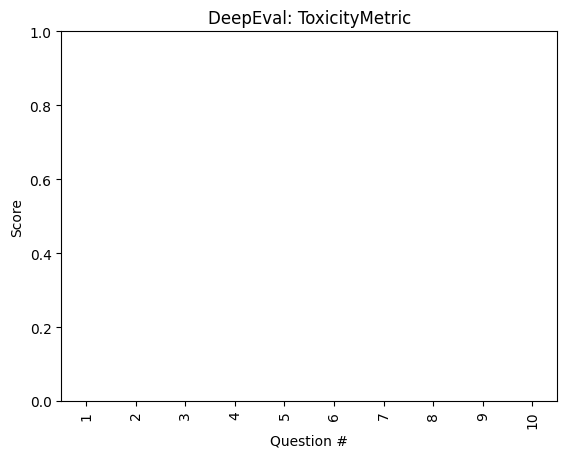

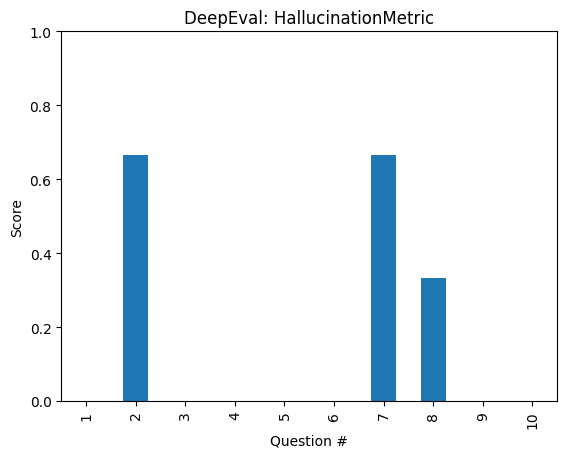

In [29]:
import time

deepeval_rows = []

for idx, row in qa_df.iterrows():
    q = row["Question"]
    ref = str(row["Reference Answer"]).strip()
    gt_chunks = str(row["Relevant Chunk IDs"])
    relevant_ids = [int(i.strip()) for i in re.split(r"[,\s]+", gt_chunks) if i.strip().isdigit()]

    docs = retriever.invoke(q)

    # Truncate docs to prevent token overflow
    context_list = [d.page_content[:1500] for d in docs[:5]]
    context = "\n\n".join(context_list)

    model = ChatGroq(groq_api_key=os.environ["GROQ_KEY"], model_name="llama3-8b-8192")
    prompt = f"Use only this context to answer:\n\n{context}\n\nQ: {q}\nA:"
    answer = model.invoke(prompt).content.strip()

    try:
        dr = evaluate_with_deepeval(q, answer, context_list, ref)
    except Exception as e:
        print(f"Evaluation failed for Q#{idx+1}: {e}")
        dr = {"Q#": idx+1, "Error": str(e)}

    dr["Q#"] = idx + 1
    deepeval_rows.append(dr)

    # Sleep to avoid rate limiting
    time.sleep(1.5)

deepeval_df = pd.DataFrame(deepeval_rows).set_index("Q#")

display(deepeval_df.style.format("{:.3f}"))

# Plot results
import matplotlib.pyplot as plt

for col in deepeval_df.columns:
    deepeval_df.plot.bar(y=col, legend=False, title=f"DeepEval: {col}")
    plt.ylim(0, 1)
    plt.ylabel("Score")
    plt.xlabel("Question #")
    plt.show()



Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]


📊 RAGAS Evaluation Results (Clean Format):
 Q#  ContextualPrecisionMetric  ContextualRecallMetric  FaithfulnessMetric  AnswerRelevancyMetric  AnswerCorrectnessMetric
  1                      1.000                   1.000               1.000                  1.000                    0.974
  2                      0.583                   0.000               1.000                  0.858                    0.383
  3                      1.000                   0.000               1.000                  0.996                    0.206
  4                      1.000                   0.000               0.000                  0.000                    0.186
  5                      1.000                   1.000               1.000                  0.978                    0.869


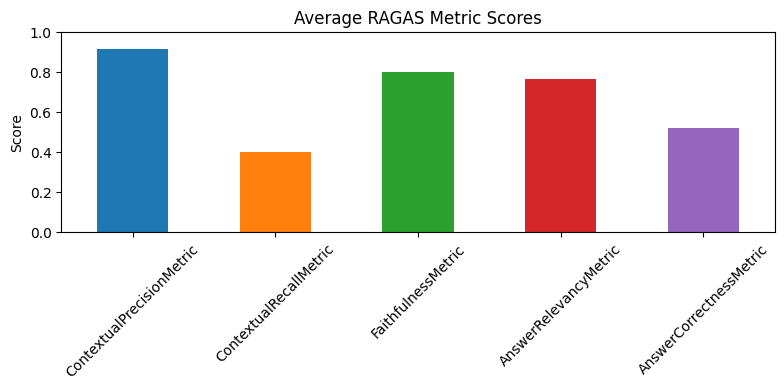

In [18]:

ragas_dataset = Dataset.from_dict({
    "question": qa_df["Question"].tolist(),
    "contexts": qa_df["contexts"].tolist(),
    "answer": qa_df["answer"].tolist(),
    "ground_truth": qa_df["Reference Answer"].tolist()
})

metrics = [
    context_precision,
    context_recall,
    faithfulness,
    answer_relevancy,
    answer_correctness
]

results = evaluate(ragas_dataset, metrics=metrics)
results_df = results.to_pandas()

metric_df = results_df.select_dtypes(include="float")

rename_map = {
    "context_precision": "ContextualPrecisionMetric",
    "context_recall": "ContextualRecallMetric",
    "faithfulness": "FaithfulnessMetric",
    "answer_relevancy": "AnswerRelevancyMetric",
    "answer_correctness": "AnswerCorrectnessMetric"
}
metric_df = metric_df.rename(columns=rename_map)

metric_df.insert(0, "Q#", range(1, len(metric_df) + 1))

pd.set_option("display.float_format", lambda x: f"{x:.3f}")

print("\nRAGAS Evaluation Results (Clean Format):")
print(metric_df.to_string(index=False))

avg_scores = metric_df.iloc[:, 1:].mean()  # exclude Q#

plt.figure(figsize=(8, 4))
avg_scores.plot.bar(color=sns.color_palette("tab10"))
plt.ylim(0, 1)
plt.title("Average RAGAS Metric Scores")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()





In [17]:
from trulens.feedback import GroundTruthAgreement
trulens_rows = []
qa_iter = qa_df.iterrows()
for idx, row in qa_iter:
    q = row["Question"]
    ref = str(row["Reference Answer"]).strip()
    model = ChatGroq(groq_api_key=os.environ["GROQ_KEY"], model_name="llama3-8b-8192")
    answer = model.invoke(q).content.strip()
    agreement = float(GroundTruthAgreement(ref)([answer])[0])
    trulens_rows.append({"Q#": idx+1, "GroundtruthAgreement": agreement})

trulens_df = pd.DataFrame(trulens_rows).set_index("Q#")
trulens_df.style.format("{:.3f}")

for col in trulens_df.columns:
    trulens_df.plot.bar(y=col, legend=False, title=f"TruLens: {col}")
    plt.ylim(0, 1)
    plt.show()


ImportError: `trulens-providers-openai` package is required for the default OpenAI provider.

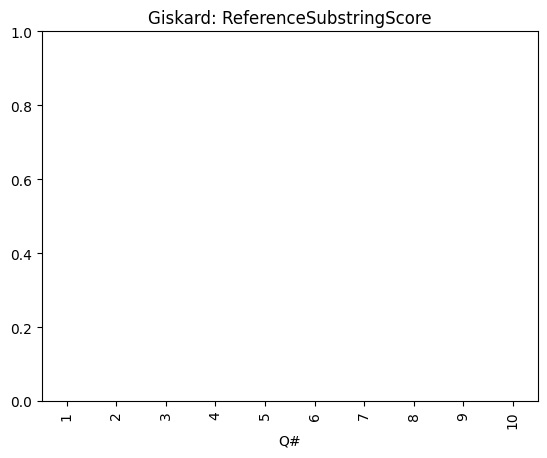

In [18]:
giskard_rows = []
for idx, row in qa_df.iterrows():
    q = row["Question"]
    ref = str(row["Reference Answer"]).strip()
    model = ChatGroq(groq_api_key=os.environ["GROQ_KEY"], model_name="llama3-8b-8192")
    answer = model.invoke(q).content.strip()
    substring_score = 1.0 if ref and (ref in answer) else 0.0
    giskard_rows.append({"Q#": idx+1, "ReferenceSubstringScore": substring_score})

giskard_df = pd.DataFrame(giskard_rows).set_index("Q#")
giskard_df.style.format("{:.3f}")

for col in giskard_df.columns:
    giskard_df.plot.bar(y=col, legend=False, title=f"Giskard: {col}")
    plt.ylim(0, 1)
    plt.show()


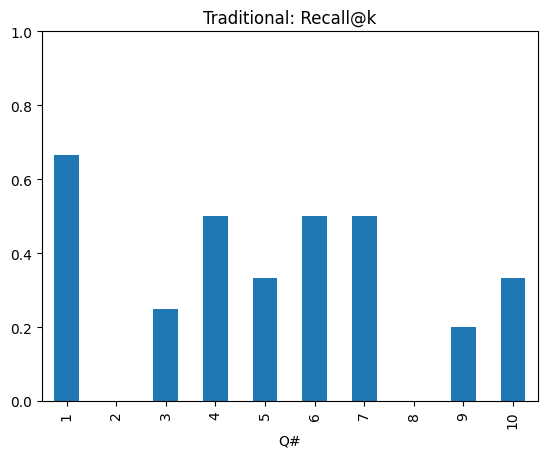

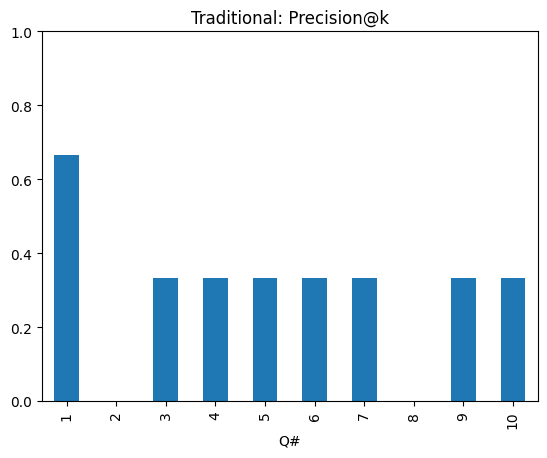

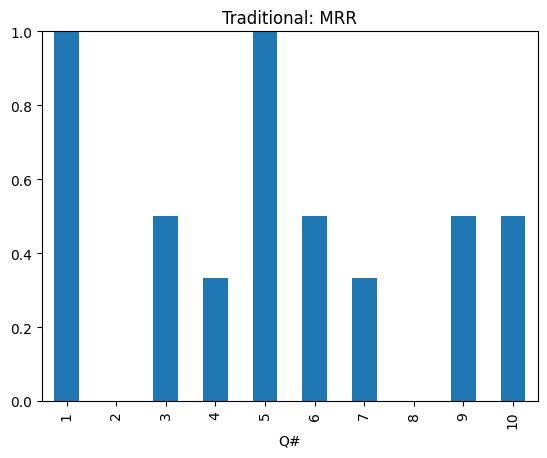

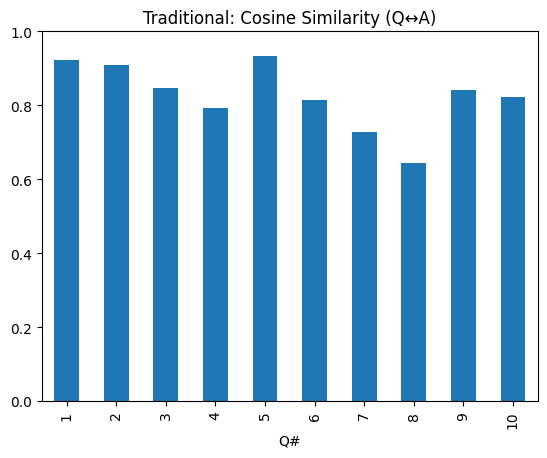

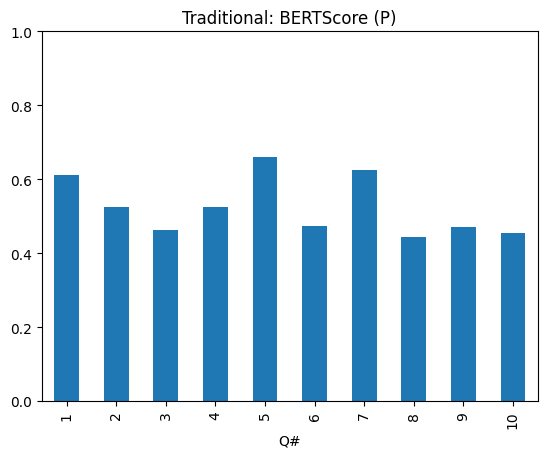

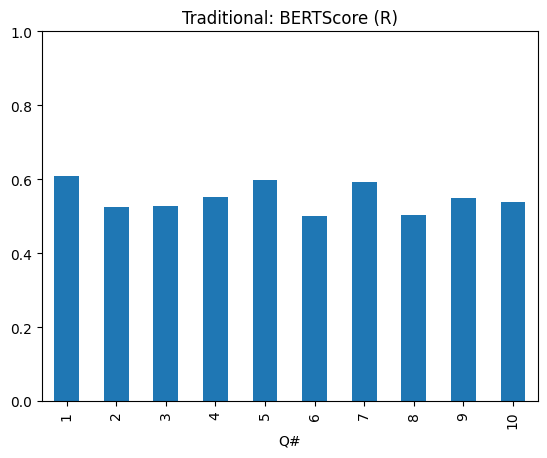

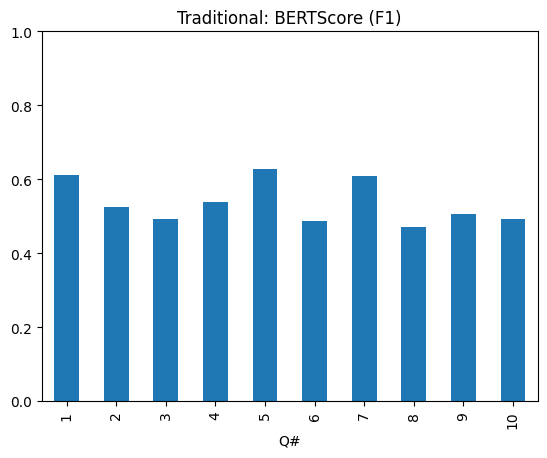

In [19]:
traditional_rows = []
for idx, row in qa_df.iterrows():
    q = row["Question"]
    gt_chunks = str(row["Relevant Chunk IDs"])
    ref = str(row["Reference Answer"]).strip()
    relevant_ids = [int(i.strip()) for i in re.split(r"[,\s]+", gt_chunks) if i.strip().isdigit()]
    docs = retriever.invoke(q)
    retrieved_ids, retrieved_docs = [], []
    for doc in docs:
        match = [i for i, c in enumerate(chunks) if c.page_content == doc.page_content]
        if match:
            retrieved_ids.append(match[0])
            retrieved_docs.append(doc)
    model = ChatGroq(groq_api_key=os.environ["GROQ_KEY"], model_name="llama3-8b-8192")
    context = "\n\n".join([d.page_content for d in retrieved_docs])
    prompt = f"Use only this context to answer:\n\n{context}\n\nQ: {q}\nA:"
    answer = model.invoke(prompt).content.strip()
    r_at_k = recall_at_k(retrieved_ids, relevant_ids, 3)
    p_at_k = precision_at_k(retrieved_ids, relevant_ids, 3)
    mrr_val = mrr(retrieved_ids, relevant_ids)
    cos_sim = answer_relevance(q, answer)
    bertP, bertR, bertF1 = bertscore(answer, ref) if ref else (None, None, None)
    traditional_rows.append({
        "Q#": idx+1, "Recall@k": r_at_k, "Precision@k": p_at_k, "MRR": mrr_val,
        "Cosine Similarity (Q↔A)": cos_sim, "BERTScore (P)": bertP, "BERTScore (R)": bertR, "BERTScore (F1)": bertF1
    })
traditional_df = pd.DataFrame(traditional_rows).set_index("Q#")
traditional_df.style.format("{:.3f}")

for col in traditional_df.columns:
    traditional_df.plot.bar(y=col, legend=False, title=f"Traditional: {col}")
    plt.ylim(0, 1)
    plt.show()


In [10]:
groq_api_key = os.environ["GROQ_KEY"]
llm = ChatGroq(groq_api_key=groq_api_key, model_name="llama3-8b-8192")
k = 3

In [11]:
traditional_rows = []

for idx, row in qa_df.iterrows():
    q = row["Question"]
    gt_chunks = str(row["Relevant Chunk IDs"])
    ref = str(row["Reference Answer"]).strip()
    relevant_ids = [int(i.strip()) for i in re.split(r"[,\s]+", gt_chunks) if i.strip().isdigit()]
    docs = retriever.invoke(q)
    retrieved_ids, retrieved_docs = [], []
    for doc in docs:
        match = [i for i, c in enumerate(chunks) if c.page_content == doc.page_content]
        if match:
            retrieved_ids.append(match[0])
            retrieved_docs.append(doc)
    prompt = f"Use only this context to answer:\n\n{chr(10).join([d.page_content for d in retrieved_docs])}\n\nQ: {q}\nA:"
    model_resp = llm.invoke(prompt)
    answer = model_resp.content if hasattr(model_resp, "content") else str(model_resp)
    answer = answer.strip()
    r_at_k = recall_at_k(retrieved_ids, relevant_ids, k)
    p_at_k = precision_at_k(retrieved_ids, relevant_ids, k)
    mrr_val = mrr(retrieved_ids, relevant_ids)
    cos_sim = answer_relevance(q, answer)
    bertP, bertR, bertF1 = bertscore(answer, ref) if ref else (None, None, None)
    traditional_rows.append({
        "Q#": idx+1, "Recall@k": r_at_k, "Precision@k": p_at_k, "MRR": mrr_val,
        "Cosine Similarity (Q↔A)": cos_sim, "BERTScore (P)": bertP, "BERTScore (R)": bertR, "BERTScore (F1)": bertF1
    })
traditional_df = pd.DataFrame(traditional_rows)
display(traditional_df.style.format("{:.3f}"))


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

,Q#,Recall@k,Precision@k,MRR,Cosine Similarity (Q↔A),BERTScore (P),BERTScore (R),BERTScore (F1)
0,1.000,0.667,0.667,1.000,0.916,0.608,0.606,0.607
1,2.000,0.000,0.000,0.000,0.918,0.547,0.545,0.546
2,3.000,0.250,0.333,0.500,0.814,0.469,0.576,0.517
3,4.000,0.500,0.333,0.333,0.874,0.536,0.547,0.541
4,5.000,0.333,0.333,1.000,0.904,0.685,0.658,0.671
5,6.000,0.500,0.333,0.500,0.853,0.510,0.530,0.520
6,7.000,0.500,0.333,0.333,0.773,0.534,0.603,0.566
7,8.000,0.000,0.000,0.000,0.581,0.476,0.536,0.504
8,9.000,0.200,0.333,0.500,0.760,0.544,0.603,0.572
9,10.000,0.333,0.333,0.500,0.742,0.450,0.537,0.490


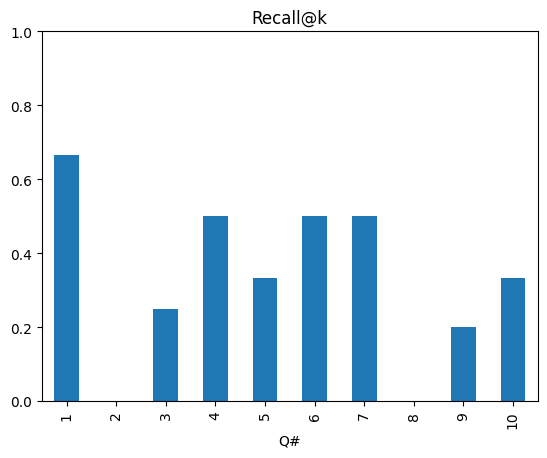

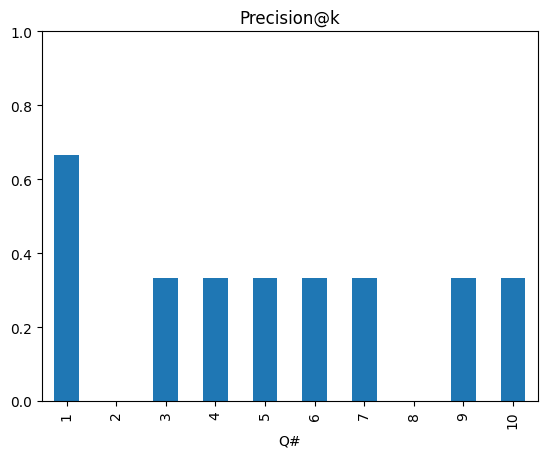

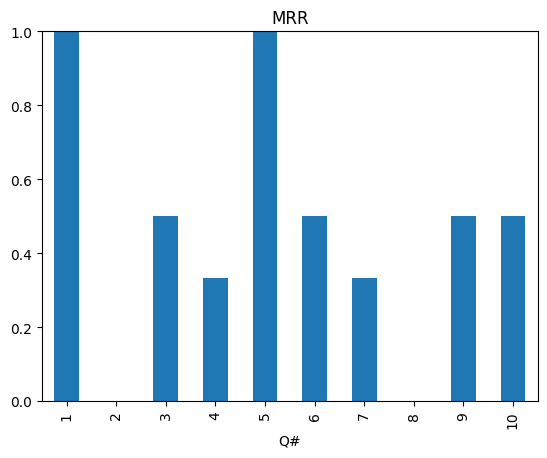

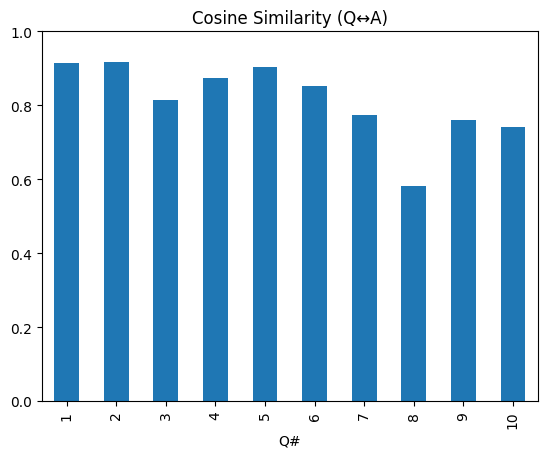

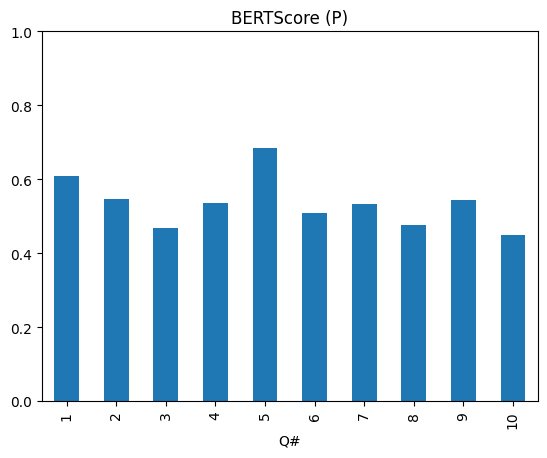

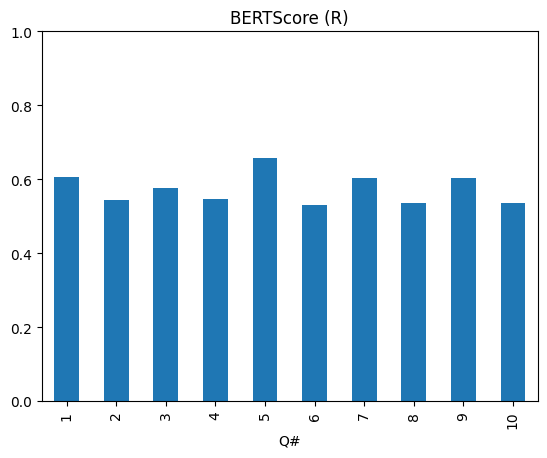

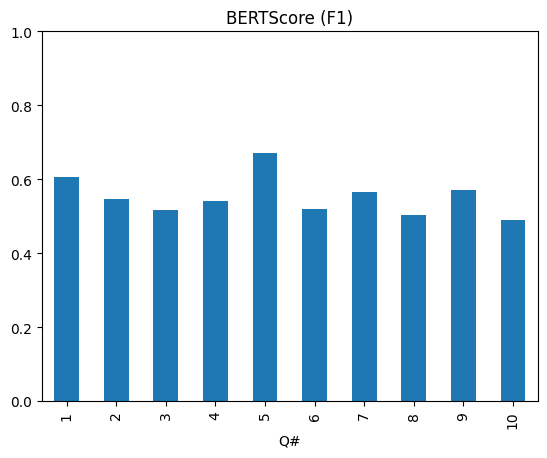

In [12]:
import matplotlib.pyplot as plt
for col in traditional_df.columns[1:]:
    traditional_df.plot.bar(x="Q#", y=col, legend=False, title=col)
    plt.ylim(0, 1)
    plt.show()
